<h2>
Simulation with the same specifications as in the experiment described
</h2>

In [1]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# welche klassen werden gebraucht?
"""
# prospect
    hat outcome probability paare
# environment
    hat liste mit individuen
# individual
    hat value function
    hat weighting function
    hat position
# value function
    hat parameter(alpha, beta, lambda)
# weighting function
    hat parameter(gamma,delta)
# absorbing barrier
    hat position
    hat geschwindigkeit (könnte auch in environment gehen)

# outcomes (?)
    hat probability
    hat size



ABLAUF DES ENVIRONMENTS:
0. spawning action
1. Generate a set of prospects
2. gamble
3. move barrier
4. eliminate
5.generate statistics?]
6. reproduce

"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import statistics  # for median


class Outcome(object):
    def __init__(self, *, probability: float, size: float):
        """ set all relevant parameters for the outcome

        Args:
            probability (float): the probability of the outcome
            size (float): the size of the outcome. This can be positive or negative
        """
        self.probability = probability
        self.size = size


class Prospect(object):
    def __init__(self, *, outcomes: list = []):
        """ Outcomes are stored in the outcomes property

        Args:
            outcomes (list, optional): Instances of Outcome. Defaults to [].
        """
        self.outcomes = outcomes

    def compute_final_result(self):
        """randomly picks a result from the outcomes. Probabilities are considered for this.
        """
        # computes the final result of the outcome
        outcome_probabilities = []
        for outcome in self.outcomes:
            outcome_probabilities.append(outcome.probability)
        self.final_result = random.choices(self.outcomes, weights=outcome_probabilities, k=1)[
            0].size  # type: float


# value function used by instances of Individual to calculate V_of_f
class ValueFunction(object):
    def __init__(self, *, lampda: float = 1, alpha: float = 1, beta: float = 1):
        """Value function used to value sizes of outcomes

        Args:
            lampda (float, optional): represents loss aversion if greater than 1. Defaults to 1.
            alpha (float, optional): represents diminishing (increasing) sensitivity for values below (above) 1. Defaults to 1.
            beta (float, optional): the same as alpha. Defaults to 1.
        """
        self.lampda = lampda
        self.alpha = alpha
        self.beta = beta

    # calculate value of a size
    def calculate(self, x: float):
        """calculate the value of a size of an outcome

        Args:
            x (float): the size, may be positive or negative

        Returns:
            float: the value of the size
        """

        # define v+
        if x >= 0:
            value = x**(self.alpha)
            return value
        # define v-
        else:
            value = -self.lampda*(-x)**(self.beta)
            return value

# weighting function used by instances of Individual to calculate V_of_f


class WeightingFunction(object):
    def __init__(self, *, gamma: float = 1, delta: float = 1):
        """Weighting function used to transform a probability into a weight

        Args:
            gamma (float, optional): Determines the weighting function for gains. Overweighting (underweighting) of small (large) probabilities, for gamma < 1. Defaults to 1.
            delta (float, optional): Determines the weighting function for losses. Same pattern as with gamma. Defaults to 1.
        """
        self.gamma = gamma  # for w+
        self.delta = delta  # for w-
    # calculate w for a probability of an outcome, depending of the sign of its size

    def calculate(self, p: float, *, positive: bool = True):
        """Compute the probability into a weight

        Args:
            p (float): probability, between 0 and 1
            positive (bool, optional): Indicates whether the associated outcome size is positive. Defaults to True.

        Returns:
            float: between 0 and 1
        """

        if positive:
            # use gamma
            weight = p**(self.gamma)/(p**(self.gamma) + (1-p)
                                      ** (self.gamma))**(1/self.gamma)
            return weight
        else:
            # use delta
            weight = p**(self.delta)/(p**(self.delta) + (1-p)
                                      ** (self.delta))**(1/self.delta)
            return weight


class Individual(object):
    def __init__(self, *, lampda: float = 1, alpha: float = 1, beta: float = 1, gamma: float = 1, delta: float = 1, position: int = 0):
        """Parameters from prospect theory

        Args:
            lampda (float, optional): risk aversion. Defaults to 1.
            alpha (float, optional): diminishing sensitivity for gains. Defaults to 1.
            beta (float, optional): diminishing sensitivity for losses. Defaults to 1.
            gamma (float, optional): weighting of probabilities for gains. Defaults to 1.
            delta (float, optional): weighting of probabilities for losses. Defaults to 1.
            position (int, optional): position of the individual. Defaults to 0.
        """
        self.lampda = lampda
        self.alpha = alpha
        self.beta = alpha  # NOTE this enforces alpha = beta, as done by Kahneman and Tversky for cumulative prospect theory
        self.gamma = gamma
        self.delta = delta
        self.position = position
        self.alive = True  # changes, when the individual "dies"
        # this holds the prospects of current decision, is filled and emptied by environment instance
        self.prospects_to_choose_from = []

        self.value_function = ValueFunction(
            lampda=self.lampda, alpha=self.alpha, beta=self.alpha)  # NOTE this enforces alpha = beta
        self.weighting_function = WeightingFunction(
            gamma=self.gamma, delta=self.delta)

    def reproduce(self, spawn_variation: float, spawn_position: int):
        """creates a new Instance of individual with similiar parameters

        Args:
            spawn_variation (float): Standard deviation of the distribution the new parameters are drawn from. Mean of the distribution is the current value
            spawn_position (int): Initial position where the individual start off.

        Returns:
            Individual: The "offspring" individual
        """

        offspring = Individual(
            lampda=np.random.normal(loc=self.lampda, scale=spawn_variation),
            # abs() is used to avoid negative parameters
            alpha=abs(np.random.normal(loc=self.alpha, scale=spawn_variation)),
            # as this causes mathematical errors
            beta=abs(np.random.normal(loc=self.beta, scale=spawn_variation)),

            gamma=np.clip(0.01, np.random.normal(
                loc=self.gamma, scale=spawn_variation), 200),  # TODO the 200 is somewhat improvised, shouldnt matter
            delta=np.clip(0.01, np.random.normal(
                loc=self.delta, scale=spawn_variation), 200),
            position=spawn_position
        )

        return offspring

    def decide_on_prospects(self):
        """consider all prospects in the prospects_to_choose_from property, choose the best and then move according to the result of the prospect
        """
        # sort the prospects by their V_of_f, from highest(best) to lowest(worst)
        self.prospects_to_choose_from.sort(
            key=lambda prospect: self.V_of_f(prospect), reverse=True)
        # pick the one with the highest V_of_f
        prospect_of_choice = self.prospects_to_choose_from[0]
        # obtain the final result of chosen prospect
        prospect_of_choice.compute_final_result()
        result = prospect_of_choice.final_result
        # update position according to result
        self.position += result

    # number function of the individual, used to decide between prospects
    def V_of_f(self, prospect: Prospect):
        """compute the number function for a given prospect

        Args:
            prospect (Prospect): The prospect to consider

        Returns:
            float: The number assigned to the prospect, the higher the better the prospect
        """
        outcomes_of_prospect = prospect.outcomes  # type: list
        # sort the list by the size of the outcomes, from worst to best
        outcomes_of_prospect.sort(key=lambda outcome: outcome.size)

        # split the prospect into positive and negative parts
        negative_sizes = []
        nonnegative_sizes = []

        negative_probabilities = []
        nonnegative_probabilities = []

        for outcome in outcomes_of_prospect:
            negative_probabilities.append(outcome.probability)
            nonnegative_probabilities.append(outcome.probability)

            # check if outcome is negative or nonnegative
            if outcome.size < 0:

                negative_sizes.append(outcome.size)
                nonnegative_sizes.append(0)
            elif outcome.size >= 0:

                negative_sizes.append(0)
                nonnegative_sizes.append(outcome.size)

        # init V+ and V-
        V_negative = 0
        V_nonnegative = 0
        # compute V-
        for i, element in enumerate(negative_sizes):
            # value of outcome weighted with the difference of the decision weights
            p_at_least_as_bad = sum(negative_probabilities[0:i+1])
            p_strictly_worse = sum(negative_probabilities[0:i])
            weighted_outcome_i = self.value_function.calculate(element) * \
                (
                self.weighting_function.calculate(p_at_least_as_bad, positive=False) -
                self.weighting_function.calculate(
                    p_strictly_worse, positive=False)
            )

            V_negative += weighted_outcome_i

        # compute V+
        for i, element in enumerate(nonnegative_sizes):
            # value of outcome weighted with the difference of the decision weights
            p_at_least_as_good = sum(nonnegative_probabilities[i:])
            p_strictly_better = sum(nonnegative_probabilities[i+1:])

            weighted_outcome_i = self.value_function.calculate(element) * \
                (
                    self.weighting_function.calculate(p_at_least_as_good, positive=True) -
                    self.weighting_function.calculate(
                        p_strictly_better, positive=True)
            )

            V_nonnegative += weighted_outcome_i

        # compute final V(prospect)
        V_total = V_negative + V_nonnegative
        return V_total


class Barrier(object):
    # set params for barrier
    def __init__(self, *, speed: float = 0.5, distribution: str = 'static', distribution_params: dict = {'sd': 1}):
        """set the parameters for the barrier

        Args:
            speed (float, optional): speed for determistic movement, mean for stochastic movement. Defaults to 0.5.
            distribution (str, optional): static is for deterministic movement, "normal" for normal distribution and "log-normal" for log-normal distribution. Defaults to 'static'.
            distribution_params (dict, optional): sd specifies the standard deviation. Defaults to {'sd': 1}.
        """
        self.speed = speed
        self.distribution = distribution
        self.distribution_params = distribution_params
        self.distribution_params['mean'] = self.speed
        self.start_position = 0
        self.position = 0
        self.last_leap_size = 0

    # move barrier according to parameters
    def move(self):

        # deterministic movement
        if self.distribution == 'static':
            increment = self.speed
        # normally distributed movement
        elif self.distribution == 'normal':
            increment = np.random.normal(
                loc=self.distribution_params['mean'], scale=self.distribution_params['sd'])
        # log-normally distributed movement
        elif self.distribution == 'log-normal':
            # expected value of a (1,1) is 4.41817
            increment = np.random.lognormal(
                mean=self.distribution_params['mean'], sigma=self.distribution_params['sd'])

        # update the position of the barrier
        self.position += increment
        # last leap size is just for statistics
        self.last_leap_size = increment


# object to store the statistics of the individuals in an environment
class Statistics(object):
    def __init__(self):
        """creates empty lists and sets time and number of indivuals to zero
        """
        self.lampdas = []
        self.alphas = []
        self.betas = []
        self.gammas = []
        self.deltas = []
        self.positions = []
        self.alives = []
        self.number_of_individuals = 0
        self.time = 0

        # across time statistics
        self.times = []
        self.time_median_lampda = []
        self.time_median_alpha = []
        self.time_median_beta = []
        self.time_median_gamma = []
        self.time_median_delta = []
        self.time_median_position = []
        self.time_number_of_individuals = []
        self.time_barrier_leap = []

        # tracker for the times of wipeouts (wipeout = no individual survived)
        self.time_wipeouts = []

# generates prospects according to arguments


class ProspectSpawner(object):
    def __init__(self, *, n_outcomes: int = 2, noisy: bool = False, noisy_sd: float = 1, expected_value: float = 0):
        """sets all relevant parameters of the prospect spawner

        Args:
            n_outcomes (int, optional): how many outcomes each prospect should have. Defaults to 2.
            noisy (bool, optional): If set to True, expected value of generated prospects is drawn from a probability distribution. Defaults to False.
            noisy_sd (float, optional): If noisy is set to True, this specifies the standard deviation of the probability distribution the prospects expected value is drawn from. Defaults to 1.
            expected_value (float, optional): The expected value for the prospect spawner. Defaults to 0.
        """
        self.n_outcomes = n_outcomes
        self.noisy = noisy
        self.noisy_sd = noisy_sd
        self.expected_value = expected_value

    # creates and returns a random prospect
    def generate_prospect(self, *, expected_value: float = None):
        """generate a random prospect

        Args:
            expected_value (float, optional): If not specified the expected value of the prospect spawner is used. Defaults to None.

        Returns:
            Prospect: A random prospect from the prospect generator
        """

        # expected value of prospect spawner can be overwritten by passing an expected value when calling this method
        if expected_value is not None:
            target_e = expected_value
        # default is taking the expected value of the prospect spawner
        else:
            target_e = self.expected_value

        # if noisy, inject noise into target_e
        if self.noisy:
            target_e = np.random.normal(loc=target_e, scale=self.noisy_sd)

        # list for unscaled probabilities of outcomes
        unscaled_probabilities = []
        for _ in range(self.n_outcomes):
            unscaled_probabilities.append(np.random.uniform(low=0.01, high=1))

        # scale probabilities to add up to 1
        scaled_probabilities = []
        unscaled_sum = sum(unscaled_probabilities)
        for element in unscaled_probabilities:
            scaled_probabilities.append(element/unscaled_sum)

        # due to pythons float calculation, probabilities sometimes add up to more than one (1.00000000000002)
        # this causes errors and thus has to be controlled for
        if sum(scaled_probabilities) > 1:
            scaled_probabilities[0] -= sum(scaled_probabilities)-1

        # untranslated sizes
        untranslated_sizes = []

        if target_e == 0:
            for _ in range(self.n_outcomes):
                untranslated_sizes.append(
                    np.random.normal(loc=target_e, scale=2))  # TODO this is arbitrary, however, target_e is hardly ever == 0
        elif target_e != 0:
            for _ in range(self.n_outcomes):
                untranslated_sizes.append(
                    np.random.normal(loc=target_e, scale=abs(target_e)))

        # compute actual e to translate sizes for reaching target_e
        actual_e = 0
        for prob, size in zip(scaled_probabilities, untranslated_sizes):
            actual_e += prob * size

        # compute the difference and subtract it from the untranslated sizes
        difference = actual_e - target_e

        translated_sizes = []
        for size in untranslated_sizes:
            translated_sizes.append(size - difference)

        outcomes = []
        # add Outcomes with computed sizes and probabilites to the Prospect
        for prob, size in zip(scaled_probabilities, translated_sizes):
            outcomes.append(Outcome(probability=prob, size=size))

        prospect = Prospect(outcomes=outcomes)
        return prospect


class Environment(object):
    def __init__(self):
        """sets basic properties of the Environment. Other properties are specified in the set_env_props method
        """

        self.individuals = []  # stores all the individuals
        self.statistics = Statistics()  # object to store statistics
        self.barrier = None  # barrier is set with set_barrier method
        self.population_grapher = PopulationGrapher(environment=self)

        # set good times to be true, this might never be used
        self.good_times = True

    # set up parameters of environment
    def set_env_props(self, *, initial_individual_position: int = 1, initial_size: int = 100, max_size: int = 100, spawn_variation: float = 0.1, initial_preferences: str = "mixed"):
        """sets relevant properties of the environment

        Args:
            initial_individual_position (int, optional): Initial position of the individuals. Defaults to 1.
            initial_size (int, optional): Initial population size. Defaults to 100.
            max_size (int, optional): Maximum size of the population. Defaults to 100.
            spawn_variation (float, optional): Standard deviation of the distribution parameters of new individuals are drawn from. Defaults to 0.1.
            initial_preferences (str, optional): "mixed" referes to even odds for rational and prospect preferences.
            Rational preferences refers to all parameters of the individual being equal to one.
            Prospect preferences refer to parameters of the individual as measured by Kahneman and Tversky. Defaults to "mixed".
        """

        self.initial_preferences = initial_preferences
        self.initial_individual_position = initial_individual_position
        self.spawn_variation = spawn_variation
        self.initial_size = initial_size
        self.max_size = max_size

    def set_prospect_spawner(self, *, prospect_spawner: ProspectSpawner):
        """links a PropsectSpawner instance to the environment

        Args:
            prospect_spawner (ProspectSpawner): the ProspectSpawner instance
        """
        # this sets the prospect spawner
        self.prospect_spawner = prospect_spawner

    def set_barrier(self, *, barrier: Barrier):
        """links a Barrier instance to the environment

        Args:
            barrier (Barrier): The Barrier instance
        """
        self.barrier = barrier  # set the barrier property to the specified barrier object

    def spawn(self, position: int = None, preferences: str = None):
        """spawn individuals into the environment

        Args:
            position (int, optional): the position at which the individuals are spawned. Defaults to None.
            preferences (str, optional): if not specified, the initial_preferences property is used. Defaults to None.
        """

        if preferences is None:
            preferences = self.initial_preferences
        if position is None:
            position = self.initial_individual_position
        for _ in range(self.initial_size):
            self.individuals.append(self.create_random_individual(
                position=self.initial_individual_position, preferences=preferences))

    def create_random_individual(self, position: int = 0, preferences: str = "rational"):
        """create a individual with random parameters

        Args:
            position (int, optional): the position the individual is spawned at. Defaults to 0.
            preferences (str, optional): the preferences of the individual. Defaults to "rational".

        Returns:
            Individual: A new instance of Individual
        """

        if preferences == "mixed":
            preferences = np.random.choice(["rational", "prospect"])

        if preferences == "rational":
            new_individual = Individual(
                # spawn an individual that maximizes expected value
                lampda=np.random.normal(loc=1, scale=self.spawn_variation),
                alpha=np.random.normal(loc=1, scale=self.spawn_variation),
                beta=np.random.normal(loc=1, scale=self.spawn_variation),
                gamma=np.random.normal(loc=1, scale=self.spawn_variation),
                delta=np.random.normal(loc=1, scale=self.spawn_variation),
                position=position
            )
        elif preferences == "prospect":
            new_individual = Individual(
                # spawn an individual with prospect theory preferences
                lampda=np.random.normal(loc=2.25, scale=self.spawn_variation),
                alpha=np.random.normal(loc=0.88, scale=self.spawn_variation),
                beta=np.random.normal(loc=0.88, scale=self.spawn_variation),
                gamma=np.random.normal(loc=0.61, scale=self.spawn_variation),
                delta=np.random.normal(loc=0.69, scale=self.spawn_variation),
                position=position
            )

        return new_individual

    def generate_prospects(self):
        """create two random prospects for each individual separately and append those to the individuals
        prospects_to_choose_from property
        """
        # adds two prospects to the prospect_to_decide_on property of the environments individuals
        for individual in self.individuals:
            prospect1 = self.prospect_spawner.generate_prospect()
            prospect2 = self.prospect_spawner.generate_prospect()

            individual.prospects_to_choose_from.append(prospect1)
            individual.prospects_to_choose_from.append(prospect2)

        # switch the good times - currently not used in any way
        if self.good_times:
            self.good_times = False
        else:
            self.good_times = True

    def gamble(self):
        """let the individuals choose their favorite prospect and move according to its result.
        Then reset the prospects_to_choose_from property to an empty list
        """
        for individual in self.individuals:
            individual.decide_on_prospects()
            individual.prospects_to_choose_from = []

    def move_barrier(self):
        """move the barrier of the environment
        """
        self.barrier.move()

    def eliminate(self):
        """remove individuals from the population whose position is behind the barrier
        """
        survivors = []
        for individual in self.individuals:
            if individual.position >= self.barrier.position:
                survivors.append(individual)
            else:
                individual.alive = False
        self.individuals = survivors

    def reproduce(self):
        """let randomly chosen individuals reproduce until the maximum population size is reached
        """
        while len(self.individuals) < self.max_size:
            random_alive_individual = random.choice(self.individuals)
            new_individual = random_alive_individual.reproduce(
                spawn_variation=self.spawn_variation,
                spawn_position=self.barrier.position + self.initial_individual_position)
            self.individuals.append(new_individual)

    def create_statistics(self):
        """create statistics for the current state of the environment
        """
        # reset all the lists
        self.statistics.lampdas = []
        self.statistics.alphas = []
        self.statistics.betas = []
        self.statistics.gammas = []
        self.statistics.deltas = []
        self.statistics.positions = []
        self.statistics.alives = []
        self.statistics.time += 1
        # fill them with the current data
        for individual in self.individuals:
            self.statistics.lampdas.append(individual.lampda)
            self.statistics.alphas.append(individual.alpha)
            self.statistics.betas.append(individual.beta)
            self.statistics.gammas.append(individual.gamma)
            self.statistics.deltas.append(individual.delta)
            self.statistics.positions.append(individual.position)
            self.statistics.alives.append(individual.alive)

    def create_time_statistics(self):
        """create time statistics from the current state of the environment, by appending the current values to the histoy of values
        """
        # time statistics of medians
        self.statistics.time_median_lampda.append(
            statistics.median(self.statistics.lampdas))

        self.statistics.time_median_alpha.append(
            statistics.median(self.statistics.alphas))

        self.statistics.time_median_beta.append(
            statistics.median(self.statistics.betas))

        self.statistics.time_median_gamma.append(
            statistics.median(self.statistics.gammas))

        self.statistics.time_median_delta.append(
            statistics.median(self.statistics.deltas))

        self.statistics.time_median_position.append(
            statistics.median(self.statistics.positions))

        self.statistics.time_number_of_individuals.append(
            len(self.individuals))

        self.statistics.time_barrier_leap.append(self.barrier.last_leap_size)
        self.statistics.times.append(self.statistics.time)

    def handle_wipeout(self):
        """handle wipeout of the entire population by spawning new individuals
        """
        print('WIPEOUT-------------')
        self.statistics.time_wipeouts.append(self.statistics.time)
        self.spawn(position=self.barrier.position + self.initial_individual_position,
                   preferences="rational")

    # execute the cycle of the environment
    def cycle(self, *, rounds: int = 1):
        """execute a whole cycle in the environment, including the following steps:
        1. generate prospects
        2. let individuals choose and move according to the result
        3. move the barrier
        4. remove individuals behind the barrier
        5. create statistics
        6. reproduce

        Args:
            rounds (int, optional): The number of cycles that are run. Defaults to 1.
        """
        for _ in range(rounds):
            # 1. generate prospects
            self.generate_prospects()
            # 2. let individuals choose and move according to the result
            self.gamble()
            # 3. move the barrier
            self.move_barrier()
            # 4. eliminate indivs behind the barrier
            self.eliminate()
            # 5. staticstics
            if len(self.individuals) <= 0:
                self.handle_wipeout()
            self.create_statistics()
            self.create_time_statistics()
            # 6. reproduce
            self.reproduce()


class PopulationGrapher(object):
    def __init__(self, environment):
        self.environment = environment
        """connects the Instance with an Instance of Environment.
        Not neccessary, as each instance of Environment gets initiliazed with its own instance of PopulationGrapher
        """

    def graph_population_combined(self, construct: bool = True, update: bool = False, show: bool = True):
        """graph the current distribution and time series data of the populations parameters.
        This method is also called by the live_graphing() method.

        Args:
            construct (bool, optional): If set to True, all plots are initialized and set up. Defaults to True.
            update (bool, optional): If set to True, the time plots are updated and rescaled with respect to their data. Defaults to False.
            show (bool, optional): If set to True the plot shows from withing the method. Defaults to True.
        """

        # 1. alphas
        # 2. betas
        # 3. lambdas
        # 4. gammas
        # 5. deltas
        # 6. positions
        # 7. time alpha beta
        # 8. time lambda
        # 9. time gamma delta
        # 10. time alives

        # CONSTRUCT THE FIGURE - ONLY DONE ONCE IN THE BEGINNING
        if construct == True:

            # set widths of the histograms' bars
            self.ALPHA_BINS = [0, 0.25, 0.5, 0.75, 1, 1.25,
                               1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
            self.LAMPDA_BINS = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5,
                                2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 5, 5.25, 5.5, 5.75, 6]
            self.GAMMA_BINS = [0, 0.25, 0.5, 0.75, 1, 1.25,
                               1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

            # set colors of the plot
            self.ALPHA_COLOR = '#1cff99'
            self.BETA_COLOR = '#ff2466'
            self.LAMPDA_COLOR = '#005859'
            self.GAMMA_COLOR = '#7affc3'
            self.DELTA_COLOR = '#ff80a6'
            self.POSITION_COLOR = '#333333'
            self.ALIVE_COLOR = '#333333'

            self.PROSPECT_COLOR = 'red'
            self.RATIONAL_COLOR = 'black'

            plt.style.use('seaborn')

            # create one figure for all stats
            self.fig_all = plt.figure(constrained_layout=True)
            gs = self.fig_all.add_gridspec(12, 4)

            # first construc the title, then set it
            # title contains:

            # initial population size
            # maximum population size
            # spawn variation

            # barrier type
            # barrier speed
            # barrier sd

            # spawner noisy
            # spawner expected
            # spawner sd

            # construct title
            text_heading = "Setup:"
            text_env = f'initial preferences: {self.environment.initial_preferences}, spawn variation: {self.environment.spawn_variation}, max size: {self.environment.max_size}'
            text_barrier = f'barrier/ -type: {self.environment.barrier.distribution}, -speed: {self.environment.barrier.speed}, -sd: {self.environment.barrier.distribution_params["sd"]}'
            text_prospect_spawner = f'prospects/ -noisy: {self.environment.prospect_spawner.noisy}, -expected value: {self.environment.prospect_spawner.expected_value}, -sd: {self.environment.prospect_spawner.noisy_sd}'

            text = text_heading + "\n" + text_env + "\n" + \
                text_barrier + "\n" + text_prospect_spawner
            # set title
            self.fig_all.suptitle(text, fontsize=12)

            # organize plots with gridspace
            # gs[row,col]
            self.hist_alpha = self.fig_all.add_subplot(gs[0:4, 0:1])
            self.hist_alpha.set_title('alpha')
            self.hist_beta = self.fig_all.add_subplot(gs[4:8, 0:1])
            self.hist_beta.set_title('beta')
            self.hist_lampda = self.fig_all.add_subplot(gs[8:12, 0:1])
            self.hist_lampda.set_title('lambda')

            self.hist_gamma = self.fig_all.add_subplot(gs[0:4, 1:2])
            self.hist_gamma.set_title('gamma')
            self.hist_delta = self.fig_all.add_subplot(gs[4:8, 1:2])
            self.hist_delta.set_title('delta')
            self.hist_position = self.fig_all.add_subplot(gs[8:12, 1:2])
            self.hist_position.set_title('position')

            self.time_alpha_beta = self.fig_all.add_subplot(gs[0:3, 2:5])
            self.time_alpha_beta.set_title('Median over time')
            self.time_alpha_beta.axhline(
                1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)
            self.time_alpha_beta.axhline(
                0.88, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)

            self.time_lampda = self.fig_all.add_subplot(gs[3:6, 2:5])
            self.time_lampda.set_title('Median over time')
            self.time_lampda.axhline(
                1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)
            self.time_lampda.axhline(
                2.25, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)

            self.time_gamma_delta = self.fig_all.add_subplot(gs[6:9, 2:5])
            self.time_gamma_delta.set_title('Median over time')
            self.time_gamma_delta.axhline(
                1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)
            self.time_gamma_delta.axhline(
                0.61, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)
            self.time_gamma_delta.axhline(
                0.69, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)

            self.time_alive = self.fig_all.add_subplot(gs[9:12, 2:5])
            self.time_alive.set_title('Population size over time')
            self.time_alive.axhline(
                self.environment.initial_size, color='gray')

        # reset histograms on update
        if update == True:
            self.hist_alpha.cla()
            self.hist_beta.cla()
            self.hist_lampda.cla()
            self.hist_gamma.cla()
            self.hist_delta.cla()
            self.hist_position.cla()

        # draw histograms
        self.hist_alpha.hist(
            self.environment.statistics.alphas, density=True, bins=self.ALPHA_BINS, color=self.ALPHA_COLOR)
        self.hist_alpha.set_title('alpha')
        self.hist_alpha.axvline(
            0.88, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)
        self.hist_alpha.axvline(
            1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)

        self.hist_beta.hist(self.environment.statistics.betas,
                            density=True, bins=self.ALPHA_BINS, color=self.BETA_COLOR)
        self.hist_beta.set_title('beta')
        self.hist_beta.axvline(
            0.88, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)
        self.hist_beta.axvline(
            1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)

        self.hist_lampda.hist(
            self.environment.statistics.lampdas, density=True, bins=self.LAMPDA_BINS, color=self.LAMPDA_COLOR)
        self.hist_lampda.set_title('lambda')
        self.hist_lampda.axvline(
            2.25, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)
        self.hist_lampda.axvline(
            1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)

        self.hist_gamma.hist(
            self.environment.statistics.gammas, density=True, bins=self.GAMMA_BINS, color=self.GAMMA_COLOR)
        self.hist_gamma.set_title('gamma')
        self.hist_gamma.axvline(
            0.61, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)
        self.hist_gamma.axvline(
            1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)

        self.hist_delta.hist(
            self.environment.statistics.deltas, density=True, bins=self.GAMMA_BINS, color=self.DELTA_COLOR)
        self.hist_delta.set_title('delta')
        self.hist_delta.axvline(
            0.69, linestyle='dotted', linewidth=1.5, color=self.PROSPECT_COLOR)
        self.hist_delta.axvline(
            1, linestyle='dotted', linewidth=1.5, color=self.RATIONAL_COLOR)

        self.hist_position.hist(
            self.environment.statistics.positions, density=True, color=self.POSITION_COLOR)
        self.hist_position.set_title('position')
        self.hist_position.axvline(
            self.environment.barrier.position, color='orange', linewidth=1.5)

        # construct line plots once in the beginning
        if construct == True:
            self.alpha_line, = self.time_alpha_beta.plot(
                self.environment.statistics.times, self.environment.statistics.time_median_alpha, color=self.ALPHA_COLOR, label='alpha')

            self.beta_line, = self.time_alpha_beta.plot(
                self.environment.statistics.times, self.environment.statistics.time_median_beta, color=self.BETA_COLOR, label='beta')

            self.lampda_line, = self.time_lampda.plot(
                self.environment.statistics.times, self.environment.statistics.time_median_lampda, color=self.LAMPDA_COLOR, label='lambda')

            self.gamma_line, = self.time_gamma_delta.plot(
                self.environment.statistics.times, self.environment.statistics.time_median_gamma, color=self.GAMMA_COLOR, label='gamma')

            self.delta_line, = self.time_gamma_delta.plot(
                self.environment.statistics.times, self.environment.statistics.time_median_delta, color=self.DELTA_COLOR, label='delta')

            self.alive_line, = self.time_alive.plot(
                self.environment.statistics.times, self.environment.statistics.time_number_of_individuals, color=self.ALIVE_COLOR, label='population size')

            # set labels, this has to be done after first plotting
            self.time_alpha_beta.legend(
                handles=[self.alpha_line, self.beta_line], loc='center left')
            self.time_lampda.legend(
                handles=[self.lampda_line], loc='center left')
            self.time_gamma_delta.legend(
                handles=[self.gamma_line, self.delta_line], loc='center left')
            self.time_alive.legend(
                handles=[self.alive_line], loc='center left')

        # update the data for the lineplots on update
        if update == True:
            self.alpha_line.set_data(
                (self.environment.statistics.times, self.environment.statistics.time_median_alpha))

            self.beta_line.set_data(
                (self.environment.statistics.times, self.environment.statistics.time_median_beta))

            self.lampda_line.set_data(
                (self.environment.statistics.times, self.environment.statistics.time_median_lampda))

            self.gamma_line.set_data(
                (self.environment.statistics.times, self.environment.statistics.time_median_gamma))

            self.delta_line.set_data(
                (self.environment.statistics.times, self.environment.statistics.time_median_delta))

            self.alive_line.set_data(
                (self.environment.statistics.times, self.environment.statistics.time_number_of_individuals))

            # rescale both axes after data has changed
            self.time_alpha_beta.relim()
            self.time_alpha_beta.autoscale_view()

            self.time_lampda.relim()
            self.time_lampda.autoscale_view()

            self.time_gamma_delta.relim()
            self.time_gamma_delta.autoscale_view()

            self.time_alive.relim()
            self.time_alive.autoscale_view()

        # show the plot on show=True
        if show == True:
            plt.show()

    # start live graphing of simulation
    def live_graphing(self, interval: int = 1000):
        """starts the live graphing of a simulation. Live graphing is significantly slower.
        It is possible to start the live graphing after running the simulation for X cycles.

        Args:
            interval (int, optional): minimum time between updates of the figure in milli seconds. Defaults to 1000.
        """
        # construct initial figure
        self.graph_population_combined(
            construct=True, update=False, show=False)

        # set an animation
        animation1 = FuncAnimation(
            fig=self.fig_all, func=self.frame_function, interval=interval)

        # show the animation
        plt.show()

    # execute the cylce method of the environment and the graping method, this is called by the FuncAnimation instance
    def frame_function(self, i):
        """run a cycle of the environment and update the statistics and graphs. This method is called by the live_graphing method.

        Args:
            i (int): parameter received by the FuncAnimation instance
        """
        self.environment.cycle()
        self.graph_population_combined(
            construct=False, update=True, show=False)


<h3>Setting up an environment</h3>

- The individuals start at position 2

- The initial and maximum population size is 500

- The spawn variation is 0.02

In [19]:
env1 = Environment()
env1.set_env_props(
    initial_individual_position=2,
    initial_size=500,
    max_size=500,
    spawn_variation=0.02
)

<h3>Set the barrier</h3>

- the barrier does not move

In [20]:
env1.set_barrier(barrier=Barrier(
    speed=0
))

<h3>Set the prospect spawner</h3>

- each individual decides between two prospects

- the prospect spawner is noisy -> the expected value of each prospect is drawn from a probability distribution

    - with standard deviation = 1
    - and mean = -1.5

In [21]:
env1.set_prospect_spawner(prospect_spawner=ProspectSpawner(
    n_outcomes=2,
    noisy=True,
    noisy_sd=1,
    expected_value=-1.5
))

<h3>Spawn the individuals and create the initial statistics for them</h3>

- mixed preferences means, that each individual is created randomly with prospect theory preferences or rational preferences (with even odds)

In [22]:
env1.spawn(preferences="mixed")
env1.create_statistics()
env1.create_time_statistics()

<h3>Let the simulation run for 1000 cycles</h3>

In [23]:
env1.cycle(rounds=1000)

<h3>Lastly, graph the results</h3>

- after the graphing, further cycles can be run and the results then graphed again

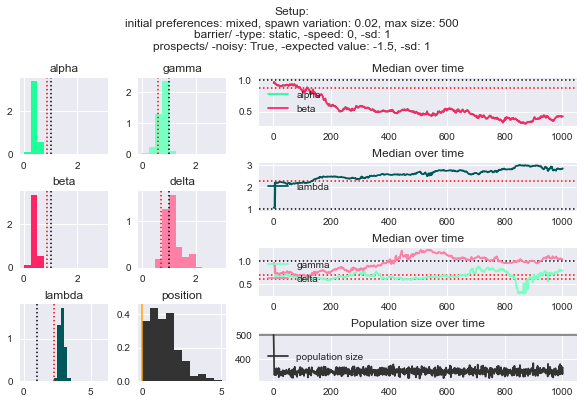

In [24]:
# final results
env1.population_grapher.graph_population_combined()